## Following this lecture

https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy


Expects a 'names.txt' file to exists in data directory.

Download with: 
`curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > data/names.txt`


import torch

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
len(words)

32033

In [84]:
chars = sorted(list(set("".join(words))))
stoi = { c:i+1  for  i,c  in enumerate(chars)}
stoi['.'] = 0
itos = { i:c for c,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f"Vocab Size {vocab_size}")

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size 27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [8]:
C.shape

torch.Size([27, 2])

In [11]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [15]:
torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

tensor([ 49590, 132155,  12887,  48555,  13670, 119758, 177279, 110846,  34539,
        157932,   5919,  76485,  19666, 173213, 158658,  60393, 125799, 140662,
        108295,  46793,  95882,  54610,  73518, 156871,  68746,  81014, 133140,
        174233,  74210, 178737, 139207,  13966])

In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 25.6358
  10000/ 200000: 2.4963
  20000/ 200000: 2.4935
  30000/ 200000: 2.3194
  40000/ 200000: 2.2860
  50000/ 200000: 2.3977
  60000/ 200000: 2.2657
  70000/ 200000: 2.3690
  80000/ 200000: 2.2076
  90000/ 200000: 2.3348
 100000/ 200000: 1.9451
 110000/ 200000: 2.0460
 120000/ 200000: 2.1954
 130000/ 200000: 2.2340
 140000/ 200000: 2.4242
 150000/ 200000: 2.3190
 160000/ 200000: 1.8493
 170000/ 200000: 2.2475
 180000/ 200000: 2.2668
 190000/ 200000: 1.8945


In [139]:
1/27

0.037037037037037035

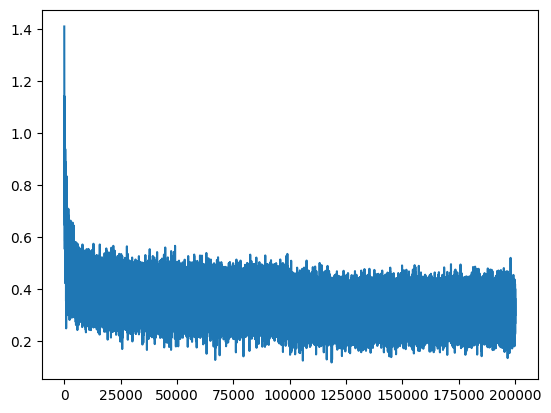

In [18]:
plt.plot(lossi)

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 2.119537115097046
val 2.161891460418701
test 2.165933847427368


In [138]:
g = torch.Generator().manual_seed(2147483647+11)

for _ in range(20):
    out = []
    context = [0] * block_size 
    word = []
    for i in range(30):
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        next_char = itos[ix]
        word += [next_char]
        context = context[1:] + [ix]
        if ix == 0:
            break
    print("".join(word))
    
    
    


naharlonephamarm.
jacey.
arzeira.
maviannatalie.
deana.
milo.
elivia.
kajanalyn.
jakhalanna.
omantlehf.
royah.
niver.
ana.
kata.
zanviyashyva.
amcee.
kerae.
nis.
tatyz.
tari.


In [75]:
next_token

tensor([3])

torch.Size([1])